# OIB Radar Crossover Analysis 
Notebook designed to analyze crossover disagreement in measurements between crossing radar tracks

At each intersecting radar profile where an interpretation has been made we have a measurement of (i.) surface elevation, (ii.) bed elevation, (iii.) ice thickness, (iv.) surface amplitude, and (v.) bed amplitude. We can compare all of these values at each radar profile intersection to analyze the disagreements in our dataset.

This loosely follows the methods of Herkommer and Whitney, 1994

BST 20211123


### psuedocode ###
1. read in dataset containing RAGU radar picks
2. find all intersection points for all radar profiles in our dataset
    2a. our dataset contains points corresponding to each "trace" in all of our radar profiles where interpretations have been made. in order to find the intersection between all our radar profiles we'll take advantage of shapely's intersection method - this requires us to first convert all points in each profile to individual linestrings
4. filter out intersections where the closest two points are above a threshold distance
3. intersections won't fall directly where we have measurements. So we'll linearly interpolate measurements at the two closest points surrounding our intersection for each profile
4. build a statistical dataset with difference in the measurements of interest between tracks at each intersection

In [1]:
### impots ###
import sys, os, itertools, math
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import spatial
import pyproj
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

%matplotlib inline
plt.rcParams["font.family"] = "Calibri"
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 8
pd.set_option('display.max_rows', 500)

In [2]:
### function declarations ###

def project_array(x=None, y=None, from_epsg=4326, to_epsg=3338, always_xy=True):
    """
    use pyproj to project our x,y data
    
    inputs:
    x = input x value array
    y = input y value array
    from_epsg = source epsg code for our x,y points
    to_epsg = destination epsg code for our points
    always_xy = boolean, whether or not input points are always in x,y order
    
    returns:
    fx = x points projected from_epsg to_epsg
    fy = y points projected from_epsg to_epsg
    """
    tform = pyproj.Transformer.from_crs(crs_from=from_epsg, crs_to=to_epsg, always_xy=always_xy)
    fx, fy = tform.transform(x, y)
    return fx,fy


def get_bearing(lat1, long1, lat2, long2):
    """
    calculate bearing in degrees between two points
    """
    dLon = (long2 - long1)
    x = math.cos(math.radians(lat2)) * math.sin(math.radians(dLon))
    y = math.cos(math.radians(lat1)) * math.sin(math.radians(lat2)) - math.sin(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.cos(math.radians(dLon))
    brng = np.arctan2(x,y)
    brng = np.degrees(brng)
    brng = (brng + 180) % 180 
    if brng == 0:
        brng = np.nan

    return brng


def euclid_dist(px, py, xarray, yarray):
  """
  calculate euclidean distance from all points in an xy array pair to a particular point

    inputs:
    px = float
    py = float
    xarray = Nx1 array containing x values
    yarray= Nx1 array containing y values
    
    returns:
    m = Nx1 array containing distance from all lon,lat points to point px,py
    
    example call:
    distance_array = euclid_distance(px=, py=, lonarray=[], latarray=[])

  """
  distance = np.sqrt( (xarray - px)**2 + (yarray - py)**2 )
  return distance


R = 6367000     # earth's radius in meters

def haversinedist_point_array(plon, plat, lonarray, latarray):
    """
    calculate the great circle distance from all points in an array to a specified point on earth's surface.
    locations specified in decimal degrees.
    
    modified from : https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    
    inputs:
    plon = float
    plat = float
    lonarray = Nx1 array containing longitude values
    latarray= Nx1 array containing latitude values
    
    returns:
    m = Nx1 array containing distance from all lon,lat points to point plon,plat
    
    example call:
    distance_array = haversinedist_point_array(plon=-140.5, plat=90.5, lonarray=[-140.1,-140.7,-141.2], latarray=[61.2,60.3,60.7])
    """
    plon, plat, lonarray, latarray = map(np.radians, [plon, plat, lonarray, latarray])  # map lat, lon to radians

    dlon = lonarray - plon
    dlat = latarray - plat

    a = np.sin(dlat/2.0)**2 + np.cos(plat) * np.cos(latarray) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = R * c
    return m



def track_crossings(lines):
    """ 
    create list of all intersecting objects.
    
    we need to take in linestrings formed from points (traces) along each radar profile in our dataset and find all the intersecting lines.
    
    we'll use shapely's intersection method for this purpose. ultimately what we want to return is a list contianing the location of each 
    crossing and the profiles participating in said crossing.
    
    input: 
    lines = list containing the name of each radar profile followed by a shapely linestring formed by all points in said profile
    
    returns:
    crossings = list containing the name of each set of intersecting radar profiles and the shapely point corresponding to their intersection
    """
    crossings = []
    for line1,line2 in  itertools.combinations(lines, 2):
        if  line1[1].intersects(line2[1]):
            crossing = line1[1].intersection(line2[1])
            if "Point" == crossing.type:
                crossings.append([line1[0],line2[0],crossing])
            elif "MultiPoint" == crossing.type:
                for pt in crossing:
                    crossings.append([line1[0],line2[0],pt])
            elif "MultiLineString" == crossing.type:
                multiLine = [line for line in crossing]
                first_coords = multiLine[0].coords[0]
                last_coords = multiLine[len(multiLine)-1].coords[1]
                crossings.append([line1[0],Point(first_coords[0], first_coords[1])])
                crossings.append([line2[0],Point(last_coords[0], last_coords[1])])
    return crossings

def interp3d(x1, y1, z1, x2, y2, z2 , x, y):
    """
    since we won't actually have measurements directly at each intersection point between radar profiles, we'll need to interpolate from our closes measurements
    
    we'll use trilinear interpolation to get our value of interest between two 3d points
    
    essentially, we have two x,y,z points surrounding our intersection location where we know x,y and need z
    
    note: i'm thinking our locations should be in projected crs for this, which they currently are not
    
    inputs:
    x1 = x location 1
    y1 = y loation 1
    z1 = z location 1
    x2 = x location 2
    y2 = y loation 2
    z2 = z location 2
    x = x location at intersection
    y = y location at intersection
    
    returns:
    z = interpolated z value at location x,y
    """
    if (x1==x2) & (y1==y2):
        z = (z1+z2)/2
    else:
        b1 = np.sqrt((x2 - x1)**2 + (y2 - y1 )**2)  # hypot between given x and y points
        b2 = np.sqrt((x - x1)**2 + (y - y1)**2)     # hypot between first x and y point and point of interest
        z =   z1 + b2*(z2 - z1) / b1                # calculate z value at point of interest

    return z


# build dataset comparing measured values at each intersection
def comp_crossings(picks_df, crossings_list, thresh_dist, thresh_brng=45):

    rem_idx = []        # indices of crossings list elements to remove if distance between closes points to  intersection are above threshold
    # initialize arrays to hold interpolated values
    x_arr = np.array(())
    y_arr = np.array(())
    track0_arr = np.array(())
    track1_arr = np.array(())
    zsrf0_arr = np.array(())
    zsrf1_arr = np.array(())
    zbed0_arr = np.array(())
    zbed1_arr = np.array(())
    thick0_arr = np.array(())
    thick1_arr = np.array(())
    brng0_arr = np.array(())
    brng1_arr = np.array(())
    beddb0_arr = np.array(())
    beddb1_arr = np.array(())

    # loop through crossings
    for _i, crossing in enumerate(crossings_list):
        pt = crossing[2]
        df_sub0 = picks_df[picks_df["track"]==crossing[0]]
        df_sub1 = picks_df[picks_df["track"]==crossing[1]]
        
        # # get distance of each point in track to intersection point
        # dist0 = haversinedist_point_array(df_sub0["lon"].to_numpy(), df_sub0["lat"].to_numpy(), 
        #         pt.x, pt.y)
        # dist1 = haversinedist_point_array(df_sub1["lon"].to_numpy(), df_sub1["lat"].to_numpy(), 
        #         pt.x, pt.y)

        # get distance of each point in track to intersection point
        dist0 = euclid_dist(pt.x, pt.y, df_sub0["x"].to_numpy(), df_sub0["y"].to_numpy())

        dist1 = euclid_dist(pt.x, pt.y, df_sub1["x"].to_numpy(), df_sub1["y"].to_numpy())

        # make sure closest point to each intersection is below threshold distance specified
        if (dist0.min() < thresh_dist) and (dist1.min() < thresh_dist):
            # sort distances to get two closest indices
            t0sort = np.argsort(dist0)
            t1sort = np.argsort(dist1)

            # get lon, lat, surface elev, thickness, and bed elev for two closest points to intersection for each track
            x0 = [df_sub0["x"].iloc[t0sort[0]], df_sub0["x"].iloc[t0sort[1]]]
            y0 = [df_sub0["y"].iloc[t0sort[0]], df_sub0["y"].iloc[t0sort[1]]]
            zsrf0 = [df_sub0["srf_elev"].iloc[t0sort[0]], df_sub0["srf_elev"].iloc[t0sort[1]]]
            zbed0 = [df_sub0["bed_elev"].iloc[t0sort[0]], df_sub0["bed_elev"].iloc[t0sort[1]]]
            thick0 = [df_sub0["srf_bed_thick"].iloc[t0sort[0]], df_sub0["srf_bed_thick"].iloc[t0sort[1]]]

            x1 = [df_sub1["x"].iloc[t1sort[0]], df_sub1["x"].iloc[t1sort[1]]]
            y1 = [df_sub1["y"].iloc[t1sort[0]], df_sub1["y"].iloc[t1sort[1]]]
            zsrf1 = [df_sub1["srf_elev"].iloc[t1sort[0]], df_sub1["srf_elev"].iloc[t1sort[1]]]
            zbed1 = [df_sub1["bed_elev"].iloc[t1sort[0]], df_sub1["bed_elev"].iloc[t1sort[1]]]
            thick1 = [df_sub1["srf_bed_thick"].iloc[t1sort[0]], df_sub1["srf_bed_thick"].iloc[t1sort[1]]]

            # get bearing between two points surrounding intersection
            # we don't really care about absolute direction here - so let's take absolute value to just get everything between 0 and 180
            brng0 = get_bearing(df_sub0["lat"].iloc[t0sort[0]], 
                                   df_sub0["lon"].iloc[t0sort[0]], 
                                   df_sub0["lat"].iloc[t0sort[1]],
                                   df_sub0["lon"].iloc[t0sort[1]])

            brng1 = get_bearing(df_sub1["lat"].iloc[t1sort[0]], 
                                   df_sub1["lon"].iloc[t1sort[0]], 
                                   df_sub1["lat"].iloc[t1sort[1]],
                                   df_sub1["lon"].iloc[t1sort[1]])
            
            if "bed_db" in picks_df:
                # get average bed power between two closest points to intersection
                beddb0 = np.mean([df_sub0["bed_db"].iloc[t0sort[0]],df_sub0["bed_db"].iloc[t0sort[1]]])
                beddb1 = np.mean([df_sub1["bed_db"].iloc[t1sort[0]],df_sub1["bed_db"].iloc[t1sort[1]]])
            else:
                beddb0 = -9999
                beddb1 = -9999

            # get linearly interpolated values for each track at intersection point
            zsrf0_cross = interp3d(x0[0],y0[0],zsrf0[0],x0[1],y0[1],zsrf0[1],pt.x,pt.y)
            zbed0_cross = interp3d(x0[0],y0[0],zbed0[0],x0[1],y0[1],zbed0[1],pt.x,pt.y)
            thick0_cross = interp3d(x0[0],y0[0],thick0[0],x0[1],y0[1],thick0[1],pt.x,pt.y)

            zsrf1_cross = interp3d(x1[0],y1[0],zsrf1[0],x1[1],y1[1],zsrf1[1],pt.x,pt.y)
            zbed1_cross = interp3d(x1[0],y1[0],zbed1[0],x1[1],y1[1],zbed1[1],pt.x,pt.y)
            thick1_cross = interp3d(x1[0],y1[0],thick1[0],x1[1],y1[1],thick1[1],pt.x,pt.y)

            if np.abs(brng0-brng1) >= thresh_brng:
                # add values to arrays
                x_arr = np.append(x_arr, pt.x)
                y_arr = np.append(y_arr, pt.y)

                brng0_arr = np.append(brng0_arr, brng0)
                brng1_arr = np.append(brng1_arr, brng1)

                track0_arr = np.append(track0_arr, crossing[0])
                zsrf0_arr = np.append(zsrf0_arr, zsrf0_cross)
                zbed0_arr = np.append(zbed0_arr, zbed0_cross)
                thick0_arr = np.append(thick0_arr, thick0_cross)

                track1_arr = np.append(track1_arr, crossing[1])
                zsrf1_arr = np.append(zsrf1_arr, zsrf1_cross)
                zbed1_arr = np.append(zbed1_arr, zbed1_cross)
                thick1_arr = np.append(thick1_arr, thick1_cross)   

                beddb0_arr = np.append(beddb0_arr, beddb0)     
                beddb1_arr = np.append(beddb1_arr, beddb1)    
            
            else:
                rem_idx.append(_i) 

        # if closest point is further than threshold, remove crossing
        else:
            rem_idx.append(_i)

    # remove crossings where closes points are above threshold distance
    for idx in sorted(rem_idx, reverse = True):  
        del crossings[idx] 

    # build df
    crossings_df = pd.DataFrame({
                                "x":x_arr, "y":y_arr, "brng0":brng0_arr, "brng1":brng1_arr,
                                 "dbrng":np.abs(brng0_arr-brng1_arr), "dbed_db":np.abs(beddb0_arr-beddb1_arr),
                                "track0":track0_arr, "zsrf0":zsrf0_arr, "zbed0":zbed0_arr, "thick0":thick0_arr,
                                "track1": track1_arr, "bed_db0":beddb0_arr, "bed_db1":beddb1_arr, 
                                 "zsrf1":zsrf1_arr, "zbed1":zbed1_arr, "thick1":thick1_arr,
                                "dzsrf":np.abs(zsrf0_arr-zsrf1_arr), "dzbed":np.abs(zbed0_arr-zbed1_arr),
                                "dthick":np.abs(thick0_arr-thick1_arr)
                                })
    return crossings_df


# create histogram to show crossover statistics
def plot_stats(crossings_df):
    # plot stats
    stats_df = crossings_df[["dzsrf","dzbed","dthick"]]
    stats_df = crossings_df[["dzbed"]]

    fig, ax = plt.subplots(1,sharex=True,figsize=((6.5,2)))
    for i, (name, col) in enumerate(stats_df.iteritems()):
        # ax = axes[
        col.hist(ax=ax,bins=len(col)//10)
        mn = ax.axvline(col.mean(), color='r', linestyle='dashed', linewidth=1,label='Mean',zorder=1000)
        std = ax.axvline(col.mean()-col.std(), color='k', linestyle='dashed', linewidth=1,label=r'$1\sigma$',zorder=1000)
        ax.axvline(col.mean()+col.std(), color='k', linestyle='dashed', linewidth=1,zorder=1000)
        # ax2 = col.plot.kde(ax=ax, secondary_y=True, label="PDF",zorder=100)
        # ax2.set_ylim(0)
        ax.set_xlim([0, 20 * np.rint(np.nanmax(col)/20)])
        ax.text(x=.85,y=.4,s='N = ' + str(len(col)), transform=ax.transAxes)
        ax.legend((mn, std), ('Mean', r'$1\sigma$'), loc='upper right')
        print("mean " + name + ": " + str(col.mean()) + " +/- " + str(col.std()))


    ax.grid(False)
    ax.set_ylabel('Crossings')
    ax.set_xlabel("Measurement Disagreement [m]")
    return fig


# gpkg is a funciton for saving picks to a geopackage/shapefile
def gpkg(fpath, df, epsg):
    # fpath is the path for where the exported csv pick file should be saved [str]
    # df pick output dataframe
    # crs is the coordinate reference system for the shapefile output
    df_copy = df.copy()
    if df_copy["x"].isnull().all() or df_copy["y"].isnull().all():
        print("no geopackage was exported due to missing gps data")
        return
    # convert lon, lat to shapely points
    geometry = [Point(xy) for xy in zip(df_copy["x"], df_copy["y"])]
    df_copy.drop(["x", "y"], axis=1)

    # create geopandas df and export
    gdf = gpd.GeoDataFrame(df, crs=epsg, geometry=geometry)
    gdf.to_file(fpath, driver="GPKG")

    return

Load RAGU radar picks

In [3]:
### params ###
dpath = "C:/Users/btober/OneDrive/Documents/MARS/orig/xtra/Ruth2022/pk_bst/"                               # data path
# dpath = "F:/MARS/orig/xtra/Ruth2022/pk_bst/"
df = gpd.read_file(dpath + 'Ruth2022_pk_bst.gpkg')                                          # use pandas to load dataset with picks
df = df[df.bed_sample.notnull()]                                                              # filter null points
thresh_dist = 50                                                                            # specify distance threshold between crossover points [m]
thresh_brng = 30
to_epsg=32605
df = df.to_crs(to_epsg)

In [4]:
# inspect dataframe
df.head()

,track,trace,lon,lat,elev,srf_sample,srf_twtt,srf_elev,srf_amp,bed_sample,bed_twtt,bed_amp,bed_elev,srf_bed_thick,geometry
0,20220501_212721,0,-150.749199,62.968637,1706.724121,33.0,0.000002,1706.724121,150.749725,52.0,0.000003,115.745796,1610.342824,96.381297,POINT (614113.892 6984091.826)
1,20220501_212721,1,-150.749184,62.968639,1706.607361,33.0,0.000002,1706.607361,150.549988,51.0,0.000003,47.507946,1615.135759,91.471602,POINT (614114.658 6984092.066)
2,20220501_212721,2,-150.749176,62.968646,1706.340454,33.0,0.000002,1706.340454,148.809097,51.0,0.000003,48.305878,1614.799401,91.541053,POINT (614115.019 6984092.823)
3,20220501_212721,3,-150.749168,62.968653,1706.073547,33.0,0.000002,1706.073547,149.828110,51.0,0.000003,48.204731,1614.466371,91.607176,POINT (614115.380 6984093.579)
4,20220501_212721,4,-150.749161,62.968649,1706.078918,33.0,0.000002,1706.078918,149.782303,51.0,0.000003,44.501232,1614.508681,91.570237,POINT (614115.781 6984093.168)


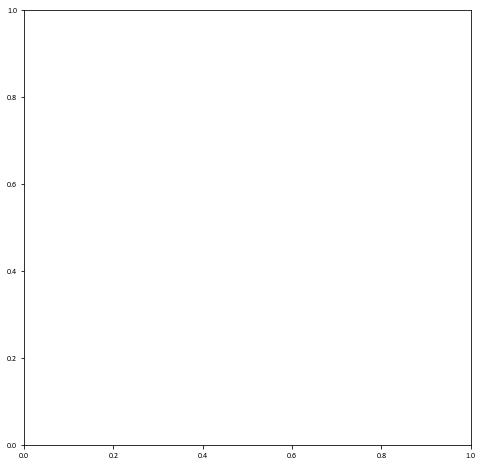

In [36]:
fig, ax = plt.subplots(1, figsize=(8,8))


all_pts = np.column_stack((df.centroid.x, df.centroid.y))
# tree = spatial.cKDTree(all_pts)
# ax.scatter(all_pts[:,0],all_pts[:,1],s=.5,color='gray')
counter = 0

for _t in df.track.unique():
# _t = df.track.unique()[-1]
    idx = df.track == _t
    pts = all_pts[idx]
    pts_ = all_pts[~idx]
    tree = spatial.cKDTree(pts)
    tree_ = spatial.cKDTree(pts_)
    indexes = tree.query_ball_tree(tree_, r=100)

    # print(_t,len(pts_)/len(pts))
    # counter = 0

    for i,l in enumerate(indexes):
        if len(l) > 0:

            counter += len(l)


In [38]:
counter

1569874

In [39]:
indexes

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [1445],
 [1440,
  1441,
  1442,
  1443,
  1444,
  1445,
  1446,
  1447,
  1448,
  1449,
  1450,
  2511,
  2512,
  2513,
  2514,
  2515,
  2516,
  2517,
  2518,
  2519,
  3701,
  3702,
  3703,
  3704,
  3705,
  3706,
  13233,
  13234,
  13235,
  13236,
  13237,
  13238,
  13239,
  13240,
  13241,
  13242],
 [1439,
  1440,
  1441,
  1442,
  1443,
  1444,
  1445,
  1446,
  1447,
  1448,
  1449,
  1450,
  1451,
  1452,
  1453,
  2509,
  2510,
  2511,
  2512,
  2513,
  2514,
  2515,
  2516,
  2517,
  2518,
  2519,
  2520,
  2521,
  3699,
  3700,
  3701,
  3702,
  3703,
  3704,
  3705,
  3706,
  3707,
  3708,
  3709,
  3710,
  13231,
  13232,
  13233,
  13234,
  13235,
  13236,
  13237,
  13238,
  13239,
  13240,
  13241,
  13242,
  13243,
  13244,
  13245,
  13246],
 [1438,
  1439,
  1440,
  1441,
  1442,
  1443,
  1444,
  1445,
  1446,
  1447,
  1448,
  1449,
  1450,
  1451,
  1452,
  1453,
  1454,
  1455,
  2508,
  250

In [24]:
print(l,r,b,t)

614369.9235199803 614709.9745655289 6984930.311557822 6985714.4211129015


In [20]:
print(np.where(len(indexes)>0))

(array([0], dtype=int64),)


In [18]:
print(indexes)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [302], [], [], [], [298], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [6991], [238, 6992], [237], [236], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [216], [], [], [], [], [], [], [], [], [], [], [], [], [], [1580], [], [], [], [], [], [], [], [], [], []]


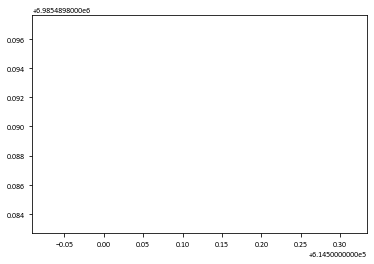

In [17]:
plt.plot(pts[58,0],pts[58,1])
plt.plot(pts_[302,0],pts_[302,1])

In [17]:
print(pts[58],pts_[302])

[ 614499.9283917  6985489.88337253] [ 614500.31491388 6985489.89695799]


In [27]:
np.linalg.norm(pts[58] - pts_[302])

0.386760865146659

In [25]:
((pts[58][0]-pts[59][0])**2-(pts[58][1]-pts[59][1])**2)**(1/2)

C:\Users\btober\AppData\Local\Temp\ipykernel_14652\498314421.py:1: RuntimeWarning: invalid value encountered in double_scalars
  ((pts[58][0]-pts[59][0])**2-(pts[58][1]-pts[59][1])**2)**(1/2)


nan

Filter dataframe to keep only IRARES1B_2021* profiles

In [5]:
# filter and keep just 2021 tracks - this can be achieved using pandas .str.contains() method


Convert lon, lat points in dataframe which are currently unprojected decimal-degrees to a projected coordinate system - let's use epsg:3338 alaska albers

This will allow us to get distance between points in meters

In [6]:
# use our project_array function defined above to convert df["lon"], df["lat"] to df["x"],df["y"]
df["x"], df["y"] = project_array(df["lon"], df["lat"], from_epsg=4326, to_epsg=to_epsg)

To look at crossover disagreement in reflectivity, we'll want to convert amplitudes to power in deciBels

$$P_{dB} = \log_{10}(a^{2})$$
$$P_{dB} = 20* \log_{10}(a)$$

where $P_{dB}$ is the power of our radar return in decibels, and $a$ is the amplitude of our return.

In [7]:
# df["p_db"] = #

Now let's get all of our profile crossings. This requires several steps:

1. convert all x,y points to shapely point objects
2. group all points by the "track" field and convert to linestrings
3. create a list containing the track name followed by the shapely linestring for each profile
4. use our track_crossings() method to get the intersections of all our profiles

In [8]:
# convert points in each track to linestring grouped by track
# zip the coordinates into a point object and convert to a shapely geodataframe
geometry = [Point(xy) for xy in zip(df.x, df.y)]
# geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf = GeoDataFrame(df, geometry=geometry)

# aggregate points by track using groupby and set as a linestring
gdf2 = gdf.groupby(["track"])["geometry"].apply(lambda x: LineString(x.tolist()))
gdf2 = GeoDataFrame(gdf2, geometry="geometry")

# compile list of lines with linestring
lines = list(gdf2["geometry"])
lines = [tuple((fname, lines[_i])) for _i, fname in enumerate(gdf2.index.values)]

# get all track crossings
crossings = track_crossings(lines)

# inspect output
# each sublist should have: ['track0', 'track1', shapelyPoint]
print(crossings[0])
# the length of our crossings list tells us how many individual radar profile intersections we have - this will likely be reduced when we account for our defined distance threshold
print(len(crossings))

['20220501_212721', '20220501_221501', <shapely.geometry.point.Point object at 0x000001A209090340>]
770


C:\Users\btober\AppData\Local\Temp\ipykernel_19724\337295934.py:116: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in crossing:


Now that we have a list of all tracks and where they cross, let's build our dataset comparing measurements at each intersection

In [9]:
# compare radar measurements at each crossing
crossings_df = comp_crossings(df, crossings, thresh_dist, thresh_brng)
# inspect output
crossings_df.head()

,x,y,brng0,brng1,dbrng,dbed_db,track0,zsrf0,zbed0,thick0,track1,bed_db0,bed_db1,zsrf1,zbed1,thick1,dzsrf,dzbed,dthick
0,614387.256544,6.985023e+06,4.086196,173.030376,168.944181,0.0,20220501_212721,1617.284444,1292.767673,324.516771,20220501_221501,-9999.0,-9999.0,1618.043042,1348.617074,269.425968,0.758597,55.849400,55.090803
1,614386.929980,6.985098e+06,178.422717,11.304947,167.117770,0.0,20220501_212721,1616.092954,1261.195748,354.897206,20220501_221501,-9999.0,-9999.0,1616.575465,1321.335123,295.240342,0.482510,60.139375,59.656865
2,614116.039537,6.984095e+06,137.730544,16.856047,120.874496,0.0,20220501_212721,1706.089057,1614.588546,91.500511,20220505_194807,-9999.0,-9999.0,1708.480541,1621.586841,86.893700,2.391484,6.998295,4.606811
3,614115.580448,6.984093e+06,137.730544,16.856020,120.874523,0.0,20220501_212721,1706.076233,1614.487526,91.588707,20220505_194807,-9999.0,-9999.0,1708.422401,1621.529042,86.893359,2.346169,7.041516,4.695348
4,615351.726465,6.986528e+06,65.753288,16.844384,48.908904,0.0,20220501_212721,1594.328045,1124.171814,470.156231,20220506_195010,-9999.0,-9999.0,1594.903552,1125.223052,469.680500,0.575507,1.051238,0.475731


Should probably just leave 20160528-224052 out of the analysis due to offset issue and since 20160528-223259 is nearly collocated and has better xover

In [10]:
# t1 = "IRARES1B_20160528-224052"
# crossings_df = crossings_df[~((crossings_df.track0==t1) | (crossings_df.track1==t1))]
# crossings_df[['dzsrf','dzbed','dthick']].describe()

In [11]:
# further inspect output stats of crossover disagreement
crossings_df[['dzsrf','dzbed','dthick']].describe()

,dzsrf,dzbed,dthick
count,81.000000,81.000000,81.000000
mean,0.631814,40.060617,39.839012
std,0.503768,32.041371,31.957398
min,0.014857,0.036440,0.089034
25%,0.278492,17.434370,17.626696
50%,0.520021,32.919662,33.251249
75%,0.811444,59.239062,59.656865
max,2.737320,172.448856,169.711536


In [12]:
arr = crossings_df["dzbed"]
q1 = np.quantile(arr,.25)
q2 = np.quantile(arr,.5)
q3 = np.quantile(arr,.75)

No handles with labels found to put in legend.


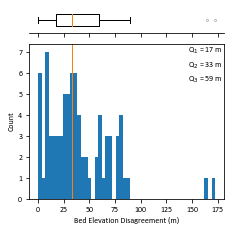

In [13]:
# create bar plot
fig, ax = plt.subplots(2,1, figsize=(3.25,3.25),gridspec_kw={'height_ratios': [.5,3]},sharex='col',sharey='row')

# box and whisker plots
flier = dict(markerfacecolor='w', marker='o', markersize='2', markeredgewidth=.25,zorder=-1000)
mp=dict(color="tab:orange", alpha=1, lw=1)
ax[0].boxplot(arr,vert=False,showfliers=True,widths=.5,flierprops=flier, medianprops=mp)

nbins=50
ax[1].hist(arr, bins=nbins)
ax[1].axvline(x=q2,c='tab:orange',lw=1)


empty_patch = mpatches.Patch(color='none', label='Extra label') # create a patch with no color
ax[1].legend()
ax[1].legend(handles=[empty_patch, empty_patch, empty_patch],
                labels=['Q' + r'$_{1}$' + ' = ' + str(round(q1)) + " m", 'Q' + r'$_{2}$' + ' = ' + str(round(q2)) + " m",'Q' + r'$_{3}$' + ' = ' + str(round(q3)) + " m"],
                loc='upper right', handlelength=0, handletextpad=0, fancybox=False, frameon=False, borderaxespad=.2, borderpad=0)

# labels
for axis in [ax[0]]:
    axis.get_yaxis().set_visible(False)
    axis.spines['left'].set_visible(False)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
ax[1].set_xlabel('Bed Elevation Disagreement (m)')
ax[1].set_ylabel('Count')

fig.tight_layout()
plt.subplots_adjust(hspace=0.125)

In [14]:
# fig.savefig("C:/Users/btober/OneDrive/Documents/pres/IGS/Maritime_2022/btober/bed_xover.png", dpi=300)

mean dzbed: 40.06061677593897 +/- 32.041370884525875


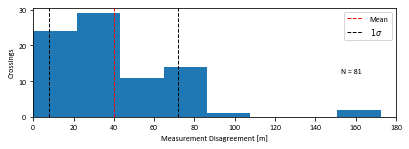

In [15]:
# plot stats
fig = plot_stats(crossings_df)
# fig.savefig(dpath + "bed_xover_hist.png", dpi=300)

In [16]:
# output crossover comparison df and geopackage

out_name = dpath + "ruth_xover2"
crossings_df.to_csv(out_name + ".csv", index=False)


gpkg(out_name + ".gpkg", crossings_df, to_epsg)